In [ ]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seed untuk reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load data
df = pd.read_csv('co2-fossil-land-use-all.csv')
df = df[df["Entity"] == "Indonesia"].copy()
df = df.dropna(subset=['Year', 'emissions_total_including_land_use_change'])
data = df[['Year', 'emissions_total_including_land_use_change']].sort_values('Year')

def iqr_outliers(data):
    outliers_indices = {}
    numeric_df = data.select_dtypes(include=['float64', 'int64'])
    q1 = numeric_df.quantile(0.25)
    q3 = numeric_df.quantile(0.75)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 + 1.5 * iqr
    for column in numeric_df.columns:
        outliers = numeric_df[(numeric_df[column] < lower_tail[column]) | (numeric_df[column] > upper_tail[column])].index
        outliers_indices[column] = list(outliers)
    return outliers_indices


def winsorize(data, cols, limits):
    for col in cols:
        q1, q3 = data[col].quantile([0.25, 0.75])
        iqr_val = q3 - q1 
        lower_bound = q1 - limits * iqr_val
        upper_bound = q3 + limits * iqr_val
        data[col] = np.clip(data[col], lower_bound, upper_bound)
    return data

num_cols = [
    'emissions_total_including_land_use_change'
]

data = winsorize(data.copy(), num_cols, 1.5)

outliers_after_winsorize = iqr_outliers(data)

for column, indices in outliers_after_winsorize.items():
    print(f"Outliers in {column} after winsorizing: {indices}") 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['emissions_total_including_land_use_change']].values.reshape(-1, 1))

def create_dataset(dataset, time_steps=10):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), :])  # Menggunakan semua fitur
        y.append(dataset[i + time_steps, 0])  # Target hanya kolom pertama (emisi)
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_dataset(scaled_data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
         kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(units=32, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(units=1, kernel_regularizer=l2(0.001))
])

model.compile(optimizer='adam', loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)


history = model.fit(X_train, y_train, epochs=50, batch_size=16, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, lr_scheduler], shuffle=False)


model.save("model_lstm.h5")
joblib.dump(scaler, "scaler.pkl")
print("Model LSTM berhasil disimpan sebagai model_lstm.h5")


train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros_like(train_predict))))[:, 0]
y_train_actual = scaler.inverse_transform(np.column_stack((y_train, np.zeros_like(y_train))))[:, 0]
test_predict = scaler.inverse_transform(np.column_stack((test_predict, np.zeros_like(test_predict))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))[:, 0]


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_actual.flatten(), test_predict.flatten())
rmse = np.sqrt(mean_squared_error(y_test_actual.flatten(), test_predict.flatten()))
mape = mean_absolute_percentage_error(y_test_actual.flatten(), test_predict.flatten())

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Outliers in Year after winsorizing: []
Outliers in emissions_total_including_land_use_change after winsorizing: []


c:\Users\M S I\Documents\skripseed\web co2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.1107 - val_loss: 0.2252 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0893 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0941 - val_loss: 0.1036 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0839 - val_loss: 0.1078 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0718 - val_loss: 0.1005 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0674 - val_loss: 0.0854 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0615 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0562 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0544 - val_loss: 0.0685 - learning_rate: 0.0010
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━

Model LSTM berhasil disimpan sebagai model_lstm.h5
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000204BCD89DA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Mean Absolute Error (MAE): 202411114.04
Root Mean Squared Error (RMSE): 227687452.87
Mean Absolute Percentage Error (MAPE): 16.41%


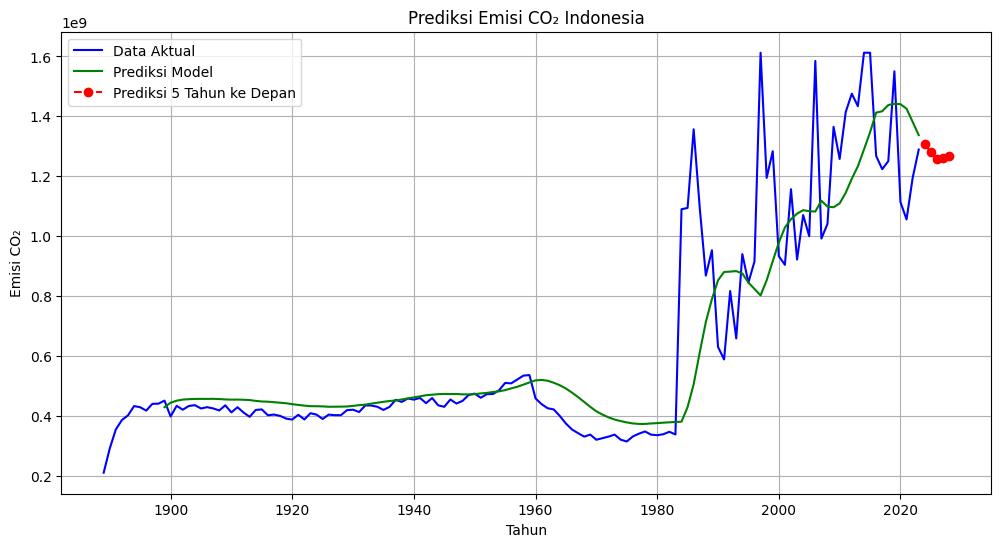


Prediksi 5 Tahun ke Depan:
 Year  Predicted CO₂ Emissions
 2024             1307780992.0
 2025             1279262208.0
 2026             1258591872.0
 2027             1261145088.0
 2028             1265872256.0


In [ ]:
# Prediksi untuk 5 Tahun ke Depan
future_steps = 5  
last_inputs = scaled_data[-time_steps:].reshape(1, time_steps, 1)

future_predictions = []

for _ in range(future_steps):
    next_pred = model.predict(last_inputs, verbose=0)[0, 0]  
    future_predictions.append(next_pred)

    last_inputs = np.append(last_inputs[:, 1:, :], [[[next_pred]]], axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_year = int(data['Year'].iloc[-1])
future_years = [last_year + i for i in range(1, future_steps + 1)]


train_years = data['Year'][time_steps:train_size+time_steps]


test_years = data['Year'][train_size+time_steps:]


full_predicted = np.concatenate((train_predict[:len(train_years)], test_predict[:len(test_years)]))
full_years = np.concatenate((train_years, test_years))


plt.figure(figsize=(12,6))
plt.plot(data['Year'], data['emissions_total_including_land_use_change'], label='Data Aktual', color='blue')


plt.plot(full_years, full_predicted, label='Prediksi Model', color='green')


plt.plot(future_years, future_predictions.flatten(), 'ro--', label='Prediksi 5 Tahun ke Depan', markersize=6)

plt.title('Prediksi Emisi CO₂ Indonesia')
plt.xlabel('Tahun')
plt.ylabel('Emisi CO₂')
plt.legend()
plt.grid()
plt.show()


prediksi_tahun_depan = pd.DataFrame({
    'Year': future_years,
    'Predicted CO₂ Emissions': future_predictions.flatten()
})

print("\nPrediksi 5 Tahun ke Depan:")
print(prediksi_tahun_depan.to_string(index=False))


In [ ]:

full_predicted = full_predicted.flatten()


actual_values = data['emissions_total_including_land_use_change'].iloc[time_steps:train_size+time_steps+len(test_years)].values


min_length = min(len(full_years), len(actual_values), len(full_predicted))


prediksi_df = pd.DataFrame({
    'Year': full_years[:min_length],
    'Actual CO₂ Emissions': actual_values[:min_length],
    'Predicted CO₂ Emissions': full_predicted[:min_length]
})

print("\nHasil Prediksi Emisi CO₂ Indonesia:")
print(prediksi_df.to_string(index=False))



Hasil Prediksi Emisi CO₂ Indonesia:
 Year  Actual CO₂ Emissions  Predicted CO₂ Emissions
 1899           450699900.0              376857312.0
 1900           397787840.0              400547648.0
 1901           433292380.0              413448864.0
 1902           420390820.0              420433056.0
 1903           432742800.0              423742592.0
 1904           435525060.0              425792768.0
 1905           424489820.0              425648896.0
 1906           428859260.0              425512736.0
 1907           424618000.0              426248864.0
 1908           417910460.0              424947424.0
 1909           434950800.0              423216928.0
 1910           411480160.0              421511104.0
 1911           428620580.0              423115616.0
 1912           410920800.0              422096608.0
 1913           396607230.0              421379616.0
 1914           419590700.0              418380640.0
 1915           421317280.0              415776448.0
 1916    